In [1]:
batch_size = 1024
STROKE_COUNT = 196
TRAIN_SAMPLES = 750
VALID_SAMPLES = 75
TEST_SAMPLES = 50

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import to_categorical
# from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from keras.metrics import top_k_categorical_accuracy
def top_3_accuracy(x,y): return top_k_categorical_accuracy(x,y, 3)
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from glob import glob
import gc
gc.enable()
# def get_available_gpus():
#     from tensorflow.python.client import device_lib
#     local_device_protos = device_lib.list_local_devices()
#     return [x.name for x in local_device_protos if x.device_type == 'GPU']

#List gpus on computer
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
print(gpu_devices)
for device in gpu_devices:
    #restrict gpu usage 
    tf.config.experimental.set_memory_growth(device, True)
base_dir = os.path.join('..', 'input')
print(base_dir)
test_path = os.path.join(base_dir, 'test_simplified.csv')
print(test_path)

2024-12-02 22:43:12.545557: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 22:43:12.581606: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 22:43:13.240380: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
../input
../input/test_simplified.csv


2024-12-02 22:43:14.111801: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-02 22:43:14.137918: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-02 22:43:14.138064: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
from ast import literal_eval
#gets the path to training data
ALL_TRAIN_PATHS = glob(os.path.join(base_dir, 'train_simplified_animals','train_simplified', '*.csv'))
COL_NAMES = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']

#takes in a string of strokes
# "[ 
#   [  // First stroke evarious pixels that are highlighted
#     [x0, x1, x2, x3, ...],
#     [y0, y1, y2, y3, ...],
#     [t0, t1, t2, t3, ...]
#   ],
#   [  // Second stroke
#     [x0, x1, x2, x3, ...],
#     [y0, y1, y2, y3, ...],
#     [t0, t1, t2, t3, ...]
#   ],
#   ... // Additional strokes
# ]"
def _stack_it(raw_strokes):
    """preprocess the string and make 
    a standard Nx3 stroke vector"""
    #converts the stroke strings to a list
    stroke_vec = literal_eval(raw_strokes) # string->list
    # unwrap the list, converts it a tuple (x, y, i)
    # (x,y) are coordinates of each indiv pixel 
    # and i is the index of each stroke
    in_strokes = [(xi,yi,i)  
     for i,(x,y) in enumerate(stroke_vec) 
     for xi,yi in zip(x,y)]
    #create a nparray with all these indiv pixels 
    #and their stroke ids
    c_strokes = np.stack(in_strokes)
    # replace stroke id with 1 for continue, 2 for new
    #changes the third column 
    #prepends 1
    #np.diff() checks whether the pixels coordinates given 
    #belong to the same stroke(same id)
    #used to determine when a new stroke began
    c_strokes[:,2] = [1]+np.diff(c_strokes[:,2]).tolist()
    c_strokes[:,2] += 1 # since 0 is no stroke
    # pad the strokes with zeros
    #N x 3 swap to 3 X N then pad with zeros
    #later swap back to (N + padding) * 3
    return pad_sequences(c_strokes.swapaxes(0, 1), 
                         maxlen=STROKE_COUNT, 
                         padding='post').swapaxes(0, 1)
#load and process csv files
#5 samples in each train csv, from row 0 to 1000
def read_batch(samples=5, 
               start_row=0,
               max_rows = 1000):
    """
    load and process the csv files
    this function is horribly inefficient but simple
    """
    out_df_list = []
    for c_path in ALL_TRAIN_PATHS:
        c_df = pd.read_csv(c_path, nrows=max_rows, skiprows=start_row)
        c_df.columns=COL_NAMES
        #picks out 5 samples of drawing and word for each object
        out_df_list += [c_df.sample(samples)[['drawing', 'word']]]
    #concat all these samples into a full dataframe
    full_df = pd.concat(out_df_list)
    full_df['drawing'] = full_df['drawing'].\
        map(_stack_it) #applies the stack function, returns padded strokes
    
    return full_df

In [4]:
#3 dict, maps the strings to numbers
train_args = dict(samples=TRAIN_SAMPLES, 
                  start_row=0, 
                  max_rows=int(TRAIN_SAMPLES*1.5))
valid_args = dict(samples=VALID_SAMPLES, 
                  start_row=train_args['max_rows']+1, 
                  max_rows=VALID_SAMPLES+25)
test_args = dict(samples=TEST_SAMPLES, 
                 start_row=valid_args['max_rows']+train_args['max_rows']+1, 
                 max_rows=TEST_SAMPLES+25)
train_df = read_batch(**train_args)
valid_df = read_batch(**valid_args)
test_df = read_batch(**test_args)
#create labels
word_encoder = LabelEncoder()
word_encoder.fit(train_df['word'])
print('words', len(word_encoder.classes_), '=>', ', '.join([x for x in word_encoder.classes_]))

words 50 => ant, bat, bear, bee, bird, butterfly, camel, cat, cow, crab, crocodile, dog, dolphin, dragon, duck, elephant, fish, flamingo, frog, giraffe, hedgehog, horse, kangaroo, lion, lobster, mermaid, monkey, mosquito, mouse, octopus, owl, panda, parrot, penguin, pig, rabbit, raccoon, rhinoceros, scorpion, sea turtle, shark, sheep, snail, snake, spider, squirrel, swan, tiger, whale, zebra


# Stroke-based Classification
Here we use the stroke information to train a model and see if the strokes give us a better idea of what the shape could be. 

In [5]:
def get_Xy(in_df):
    X = np.stack(in_df['drawing'], 0)
    y = to_categorical(word_encoder.transform(in_df['word'].values))
    return X, y
train_X, train_y = get_Xy(train_df)
valid_X, valid_y = get_Xy(valid_df)
test_X, test_y = get_Xy(test_df)
print(train_X.shape)

(37500, 196, 3)


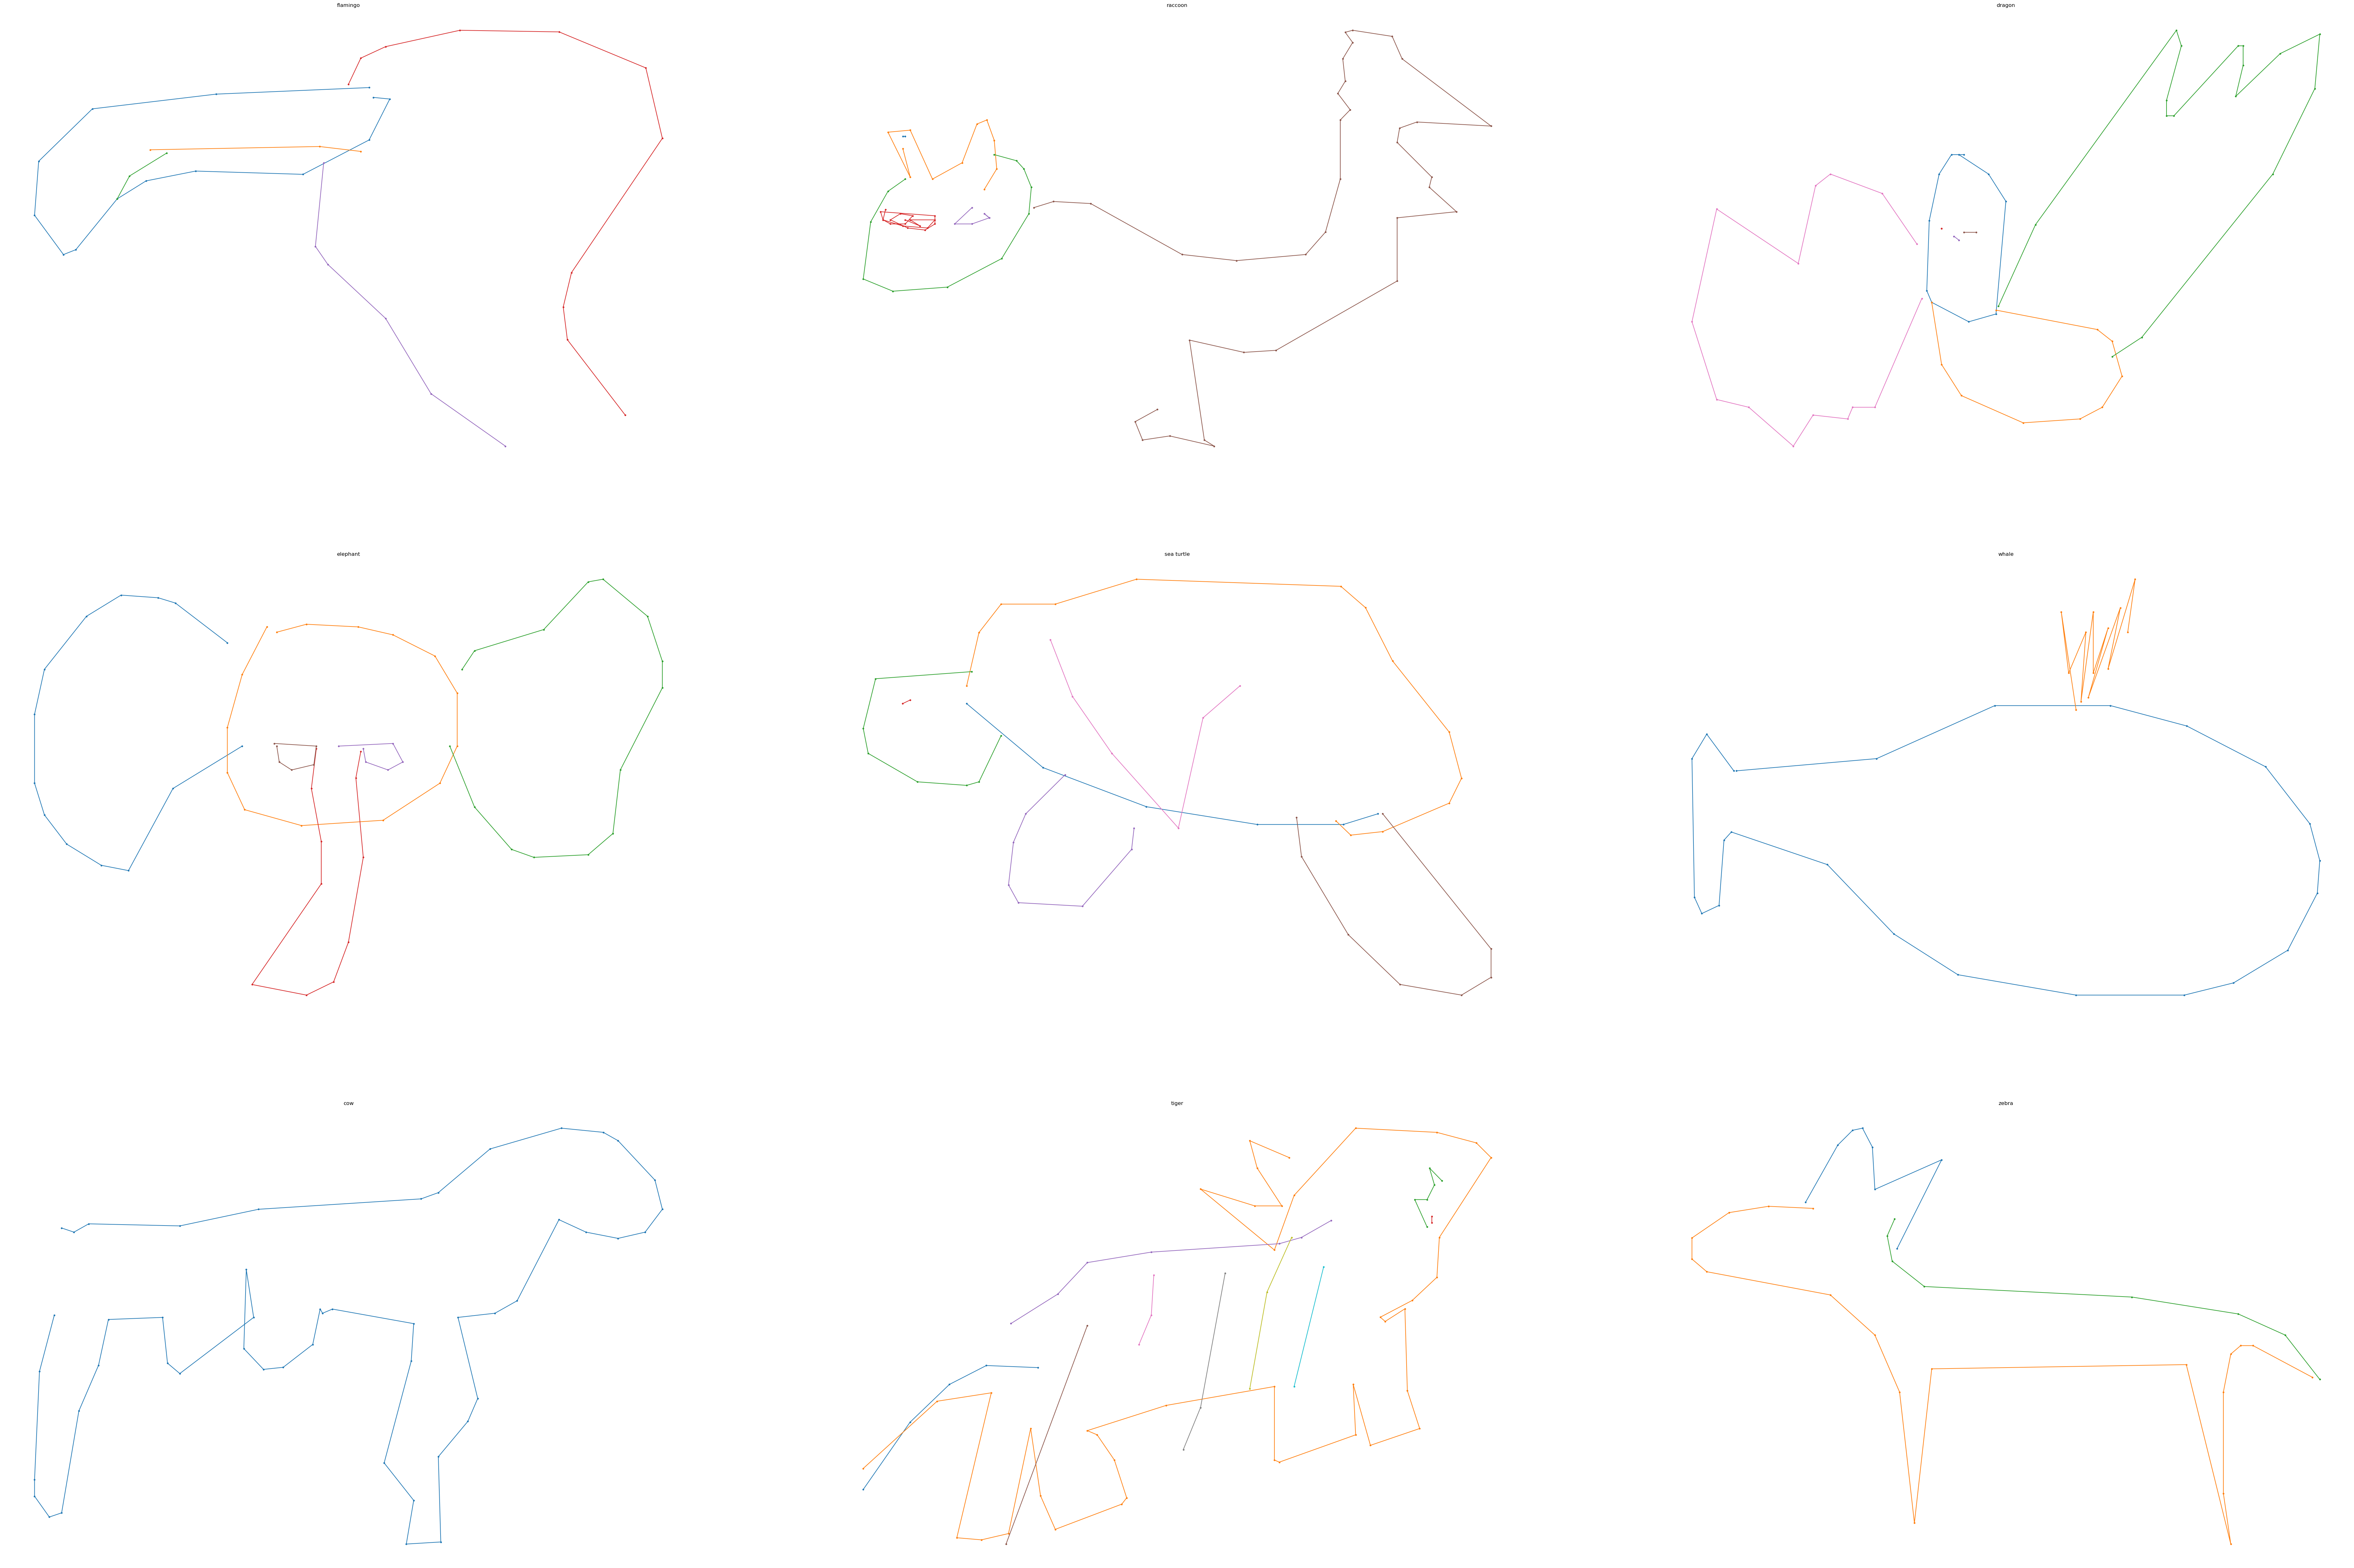

In [6]:
#3x3 canvas
fig, m_axs = plt.subplots(3,3, figsize = (96, 64))
#choose 9 random drawings
rand_idxs = np.random.choice(range(train_X.shape[0]), size = 9)
for c_id, c_ax in zip(rand_idxs, m_axs.flatten()):
    test_arr = train_X[c_id]
    #filters out stroke = 0 (no stroke)
    test_arr = test_arr[test_arr[:,2]>0, :] # only keep valid points
    lab_idx = np.cumsum(test_arr[:,2]-1) 
    #cumulative sum -1, easier to distinguish each stroke

    for i in np.unique(lab_idx):
        c_ax.plot(test_arr[lab_idx==i,0], 
                np.max(test_arr[:,1])-test_arr[lab_idx==i,1], '.-')
    c_ax.axis('off')
    c_ax.set_title(word_encoder.classes_[np.argmax(train_y[c_id])])

In [8]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv1D, LSTM, Dense, Dropout 

stroke_read_model = Sequential()
stroke_read_model.add(BatchNormalization(input_shape = (196,)+train_X.shape[2:]))
stroke_read_model.add(Conv1D(48, (5,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Conv1D(64, (5,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Conv1D(96, (3,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(LSTM(128, return_sequences = True))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(LSTM(128, return_sequences = False))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Dense(512))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Dense(len(word_encoder.classes_), activation = 'softmax'))
stroke_read_model.compile(optimizer = 'adam', 
                          loss = 'categorical_crossentropy', 
                          metrics = ['categorical_accuracy', top_3_accuracy])
stroke_read_model.summary()
with open('stroke_read_model' + '.json', 'w') as outfile:
    outfile.write(stroke_read_model.to_json())

/home/monkescripts/.local/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-12-02 22:44:18.920924: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-02 22:44:18.921249: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
202

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 196, 3)         │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 192, 48)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 192, 48)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 188, 64)        │        15,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 188, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 186, 96)        │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 186, 96)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 186, 128)       │       115,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 186, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        25,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,214 (1.42 MB)

 Trainable params: 373,208 (1.42 MB)

 Non-trainable params: 6 (24.00 B)

In [10]:
import os
directory = "weights/"
if not os.path.exists(directory):
    os.makedirs(directory)
weight_path="{}{}.weights.h5".format(directory, 'stroke_lstm_model')
print(weight_path)
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, 
                                   verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

weights/stroke_lstm_model.weights.h5


In [11]:
from IPython.display import clear_output
stroke_read_model.fit(train_X, train_y,
                      validation_data = (valid_X, valid_y), 
                      batch_size = batch_size,
                      epochs = 400,
                      callbacks = callbacks_list)
clear_output()

Epoch 1/400


2024-12-02 22:44:36.996518: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


KeyboardInterrupt: 

In [12]:
stroke_read_model.load_weights(weight_path)
lstm_results = stroke_read_model.evaluate(test_X, test_y, batch_size = 1024)
print('Accuracy: %2.1f%%, Top 3 Accuracy %2.1f%%' % (100*lstm_results[1], 100*lstm_results[2]))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - categorical_accuracy: 0.5419 - loss: 1.7557 - top_3_accuracy: 0.7384
Accuracy: 54.2%, Top 3 Accuracy 74.2%


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
              precision    recall  f1-score   support

         ant       0.53      0.70      0.60        50
         bat       0.53      0.52      0.53        50
        bear       0.29      0.28      0.29        50
         bee       0.74      0.50      0.60        50
        bird       0.41      0.26      0.32        50
   butterfly       0.86      0.76      0.81        50
       camel       0.63      0.80      0.71        50
         cat       0.62      0.50      0.56        50
         cow       0.55      0.56      0.55        50
        crab       0.59      0.52      0.55        50
   crocodile       0.51      0.50      0.51        50
         dog       0.36      0.20      0.26        50
     dolphin       0.56      0.50      0.53        50
      dragon       0.27      0.32      0.29        50
        duck       0.48      0.52      0.50        50
    elephant       0.30      0.42      0.35        50
        fish       0.75      0.76      0.7

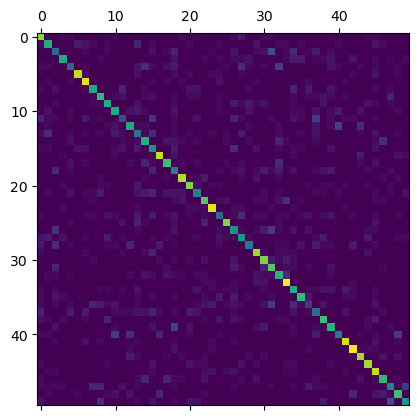

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
test_cat = np.argmax(test_y, 1)
pred_y = stroke_read_model.predict(test_X, batch_size = 1024)
pred_cat = np.argmax(pred_y, 1)
plt.matshow(confusion_matrix(test_cat, pred_cat))
print(classification_report(test_cat, pred_cat, 
                            target_names = [x for x in word_encoder.classes_]))

# Reading Point by Point

In [17]:
points_to_use = [5, 15, 20, 30, 40, 50]
points_to_user = [108]
samples = 12
word_dex = lambda x: word_encoder.classes_[x]
rand_idxs = np.random.choice(range(test_X.shape[0]), size = samples)
fig, m_axs = plt.subplots(len(rand_idxs), len(points_to_use), figsize = (24, samples/8*24))
for c_id, c_axs in zip(rand_idxs, m_axs):
    res_idx = np.argmax(test_y[c_id])
    goal_cat = word_encoder.classes_[res_idx]

    for pt_idx, (pts, c_ax) in enumerate(zip(points_to_use, c_axs)):
        test_arr = test_X[c_id, :].copy()
        test_arr[pts:] = 0 # short sequences make CudnnLSTM crash, ugh 
        stroke_pred = stroke_read_model.predict(np.expand_dims(test_arr,0))[0]
        top_10_idx = np.argsort(-1*stroke_pred)[:10]
        top_10_sum = np.sum(stroke_pred[top_10_idx])

        test_arr = test_arr[test_arr[:,2]>0, :] # only keep valid points
        lab_idx = np.cumsum(test_arr[:,2]-1)
        for i in np.unique(lab_idx):
            c_ax.plot(test_arr[lab_idx==i,0], 
                    np.max(test_arr[:,1])-test_arr[lab_idx==i,1], # flip y
                      '.-')
        c_ax.axis('off')
        if pt_idx == (len(points_to_use)-1):
            c_ax.set_title('Answer: %s (%2.1f%%) \nPredicted: %s (%2.1f%%)' % (goal_cat, 100*stroke_pred[res_idx]/top_10_sum, word_dex(top_10_idx[0]), 100*stroke_pred[top_10_idx[0]]/top_10_sum))
        else:
            c_ax.set_title('%s (%2.1f%%), %s (%2.1f%%)\nCorrect: (%2.1f%%)' % (word_dex(top_10_idx[0]), 100*stroke_pred[top_10_idx[0]]/top_10_sum, 
                                                                 word_dex(top_10_idx[1]), 100*stroke_pred[top_10_idx[1]]/top_10_sum, 
                                                                 100*stroke_pred[res_idx]/top_10_sum))
# After creating the plot, save it as a PNG
plt.tight_layout()  # Adjust spacing between subplots
plt.savefig("plot_output.png", dpi=300, bbox_inches="tight")
plt.close()  # Close the figure to free up memory

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

In [18]:
import hls4ml
config = hls4ml.utils.config_from_keras_model(stroke_read_model, granularity="name")
print("-----------------------------------")
print("Configuration")
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    stroke_read_model,
    hls_config=config,
    output_dir="my-hls-test",
    part="xc7a35tcpg236-1",
)
#hls_model.compile()

hello
model arch loaded from json {'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential_1', 'trainable': True, 'dtype': 'float32', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 196, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_

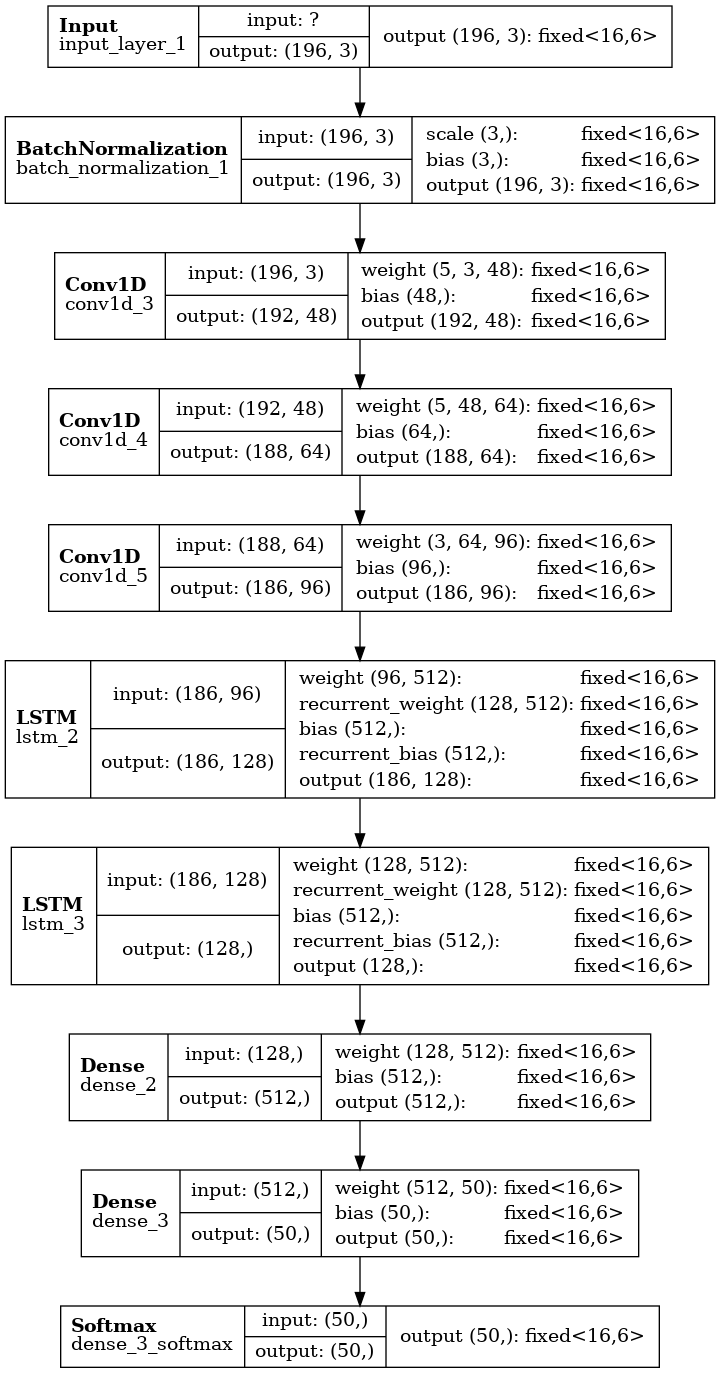

In [13]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [14]:
hls_model.compile()
# X_test = np.ascontiguousarray(X_test)
# y_hls = hls_model.predict(X_test)

Writing HLS project


Done


In [15]:
hls_model.build(csim=False)

Exception: Vivado HLS installation not found. Make sure "vivado_hls" is on PATH.

In [28]:
sub_df = pd.read_csv(test_path)
sub_df['drawing'] = sub_df['drawing'].map(_stack_it)

In [3]:
sub_vec = np.stack(sub_df['drawing'].values, 0)
sub_pred = stroke_read_model.predict(sub_vec, verbose=True, batch_size=1024)

NameError: name 'np' is not defined

In [30]:
top_3_pred = [word_encoder.classes_[np.argsort(-1*c_pred)[:3]] for c_pred in sub_pred]

In [31]:
top_3_pred = [' '.join([col.replace(' ', '_') for col in row]) for row in top_3_pred]
top_3_pred[:3]

['bee whale snail', 'mouse fish shark', 'camel bat bird']

NameError: name 'sub_vec' is not defined

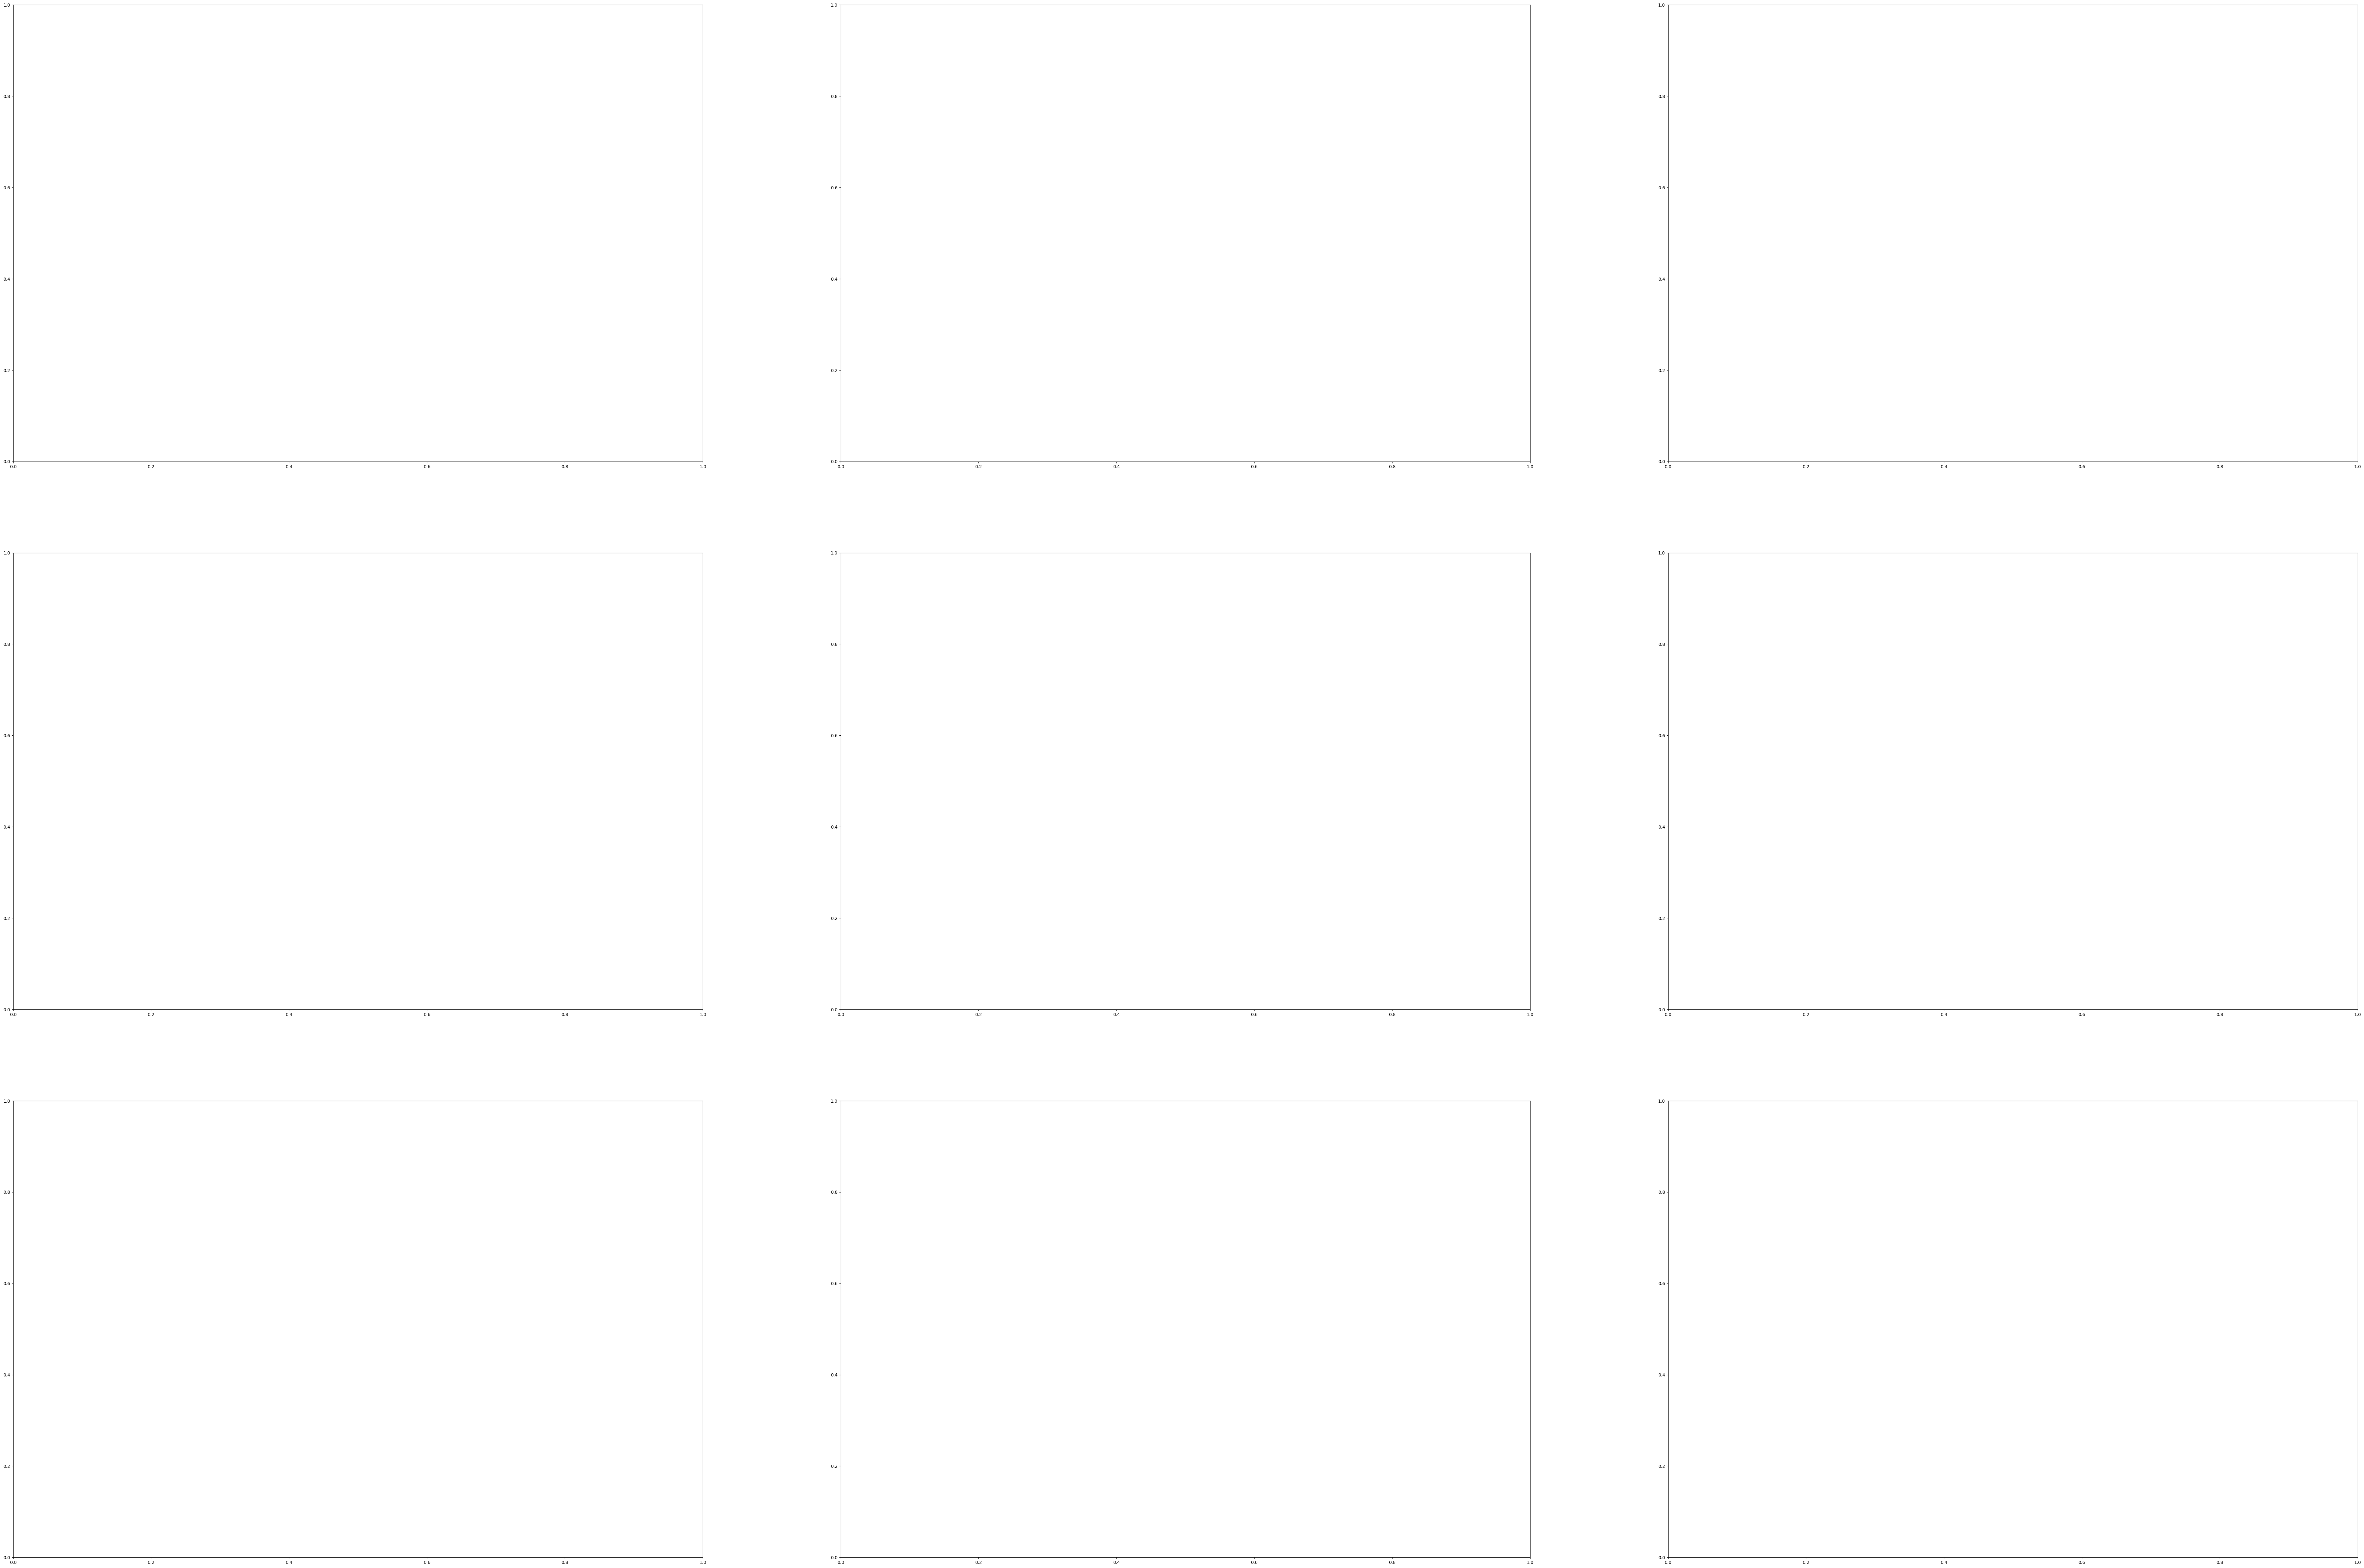

In [16]:
fig, m_axs = plt.subplots(3,3, figsize = (96, 64))
rand_idxs = np.random.choice(range(sub_vec.shape[0]), size = 9)
for c_id, c_ax in zip(rand_idxs, m_axs.flatten()):
    test_arr = sub_vec[c_id]
    test_arr = test_arr[test_arr[:,2]>0, :] # only keep valid points
    lab_idx = np.cumsum(test_arr[:,2]-1)
    for i in np.unique(lab_idx):
        c_ax.plot(test_arr[lab_idx==i,0], 
                np.max(test_arr[:,1])-test_arr[lab_idx==i,1], '.-')
    c_ax.axis('off')
    c_ax.set_title(top_3_pred[c_id])

In [33]:
sub_df['word'] = top_3_pred
sub_df[['key_id', 'word']].to_csv('submission.csv', index=False)